https://www.tensorflow.org/tutorials/keras/text_classification

# Exercise: multi-class classification on stackoverflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on Stack Overflow.

A dataset has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on BigQuery, which contains more than 17 million posts.

In [1]:
import os
import re
import shutil
import string

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, losses

In [2]:
print(tf.__version__)

2.9.1


In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset = tf.keras.utils.get_file(
    'stack_overflow_16k',
    url,
    untar=True,
    cache_dir='data',
    cache_subdir='stackoverflow'
)

dataset_dir = os.path.dirname(dataset)

6053168/6053168 [==============================] - 0s 0us/step


In [4]:
os.listdir(dataset_dir)

['README.md', 'stack_overflow_16k.tar.gz', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [7]:
sample_file = os.path.join(train_dir, 'python/9.txt')

with open(sample_file) as f:
    print(f.read())

"combining map with zip through lambda i'm trying to write a function for adding 2d vectors. .i'm trying to combine the map() function, getting a list using the zip() function (which will zip 2 tuples)...this is the code:..a = (1, 2).b = (3, 4).c = list(map(lambda x, y: x+y, list(zip(a, b)))).print(c)...so the way i see it, zip(a, b) returns a zip object containing the following tuples: (1, 3), (2, 4). it is then converted to a list. i'm getting the following error:...  typeerror: () missing 1 required positional argument: 'y'...so my guess is that the lambda function is not taking the second number in each tuple...is there any way to do this?"



In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'data/stackoverflow/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print(f'Question: {text_batch.numpy()[i]}')
        print(f'Label: {label_batch.numpy()[i]}')

Question: b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default cons

In [10]:
print(f'Label 0 corresponds to: {raw_train_ds.class_names[0]}')
print(f'Label 1 corresponds to: {raw_train_ds.class_names[1]}')
print(f'Label 2 corresponds to: {raw_train_ds.class_names[2]}')
print(f'Label 3 corresponds to: {raw_train_ds.class_names[3]}')

Label 0 corresponds to: csharp
Label 1 corresponds to: java
Label 2 corresponds to: javascript
Label 3 corresponds to: python


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'data/stackoverflow/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'data/stackoverflow/test', 
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

    return tf.strings.regex_replace(
        stripped_html,
        f'[{re.escape(string.punctuation)}]',
        ''
    )

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [15]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print(f'Review: {first_question}')
print(f'Label: {raw_train_ds.class_names[first_label]}')
print(f'Vectorized review: {vectorize_text(first_question, first_label)}')

Review: b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extra bits of

In [18]:
print(f'1287 ---> {vectorize_layer.get_vocabulary()[1287]}')
print(f' 313 ---> {vectorize_layer.get_vocabulary()[313]}')
print(f'Vocabulary size: {len(vectorize_layer.get_vocabulary())}')

1287 ---> saw
 313 ---> source
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

In [23]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [24]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
200/200 [==============================] - 4s 13ms/step - loss: 1.3791 - accuracy: 0.3325 - val_loss: 1.3671 - val_accuracy: 0.5163
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3495 - accuracy: 0.4700 - val_loss: 1.3268 - val_accuracy: 0.5431
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2975 - accuracy: 0.5370 - val_loss: 1.2642 - val_accuracy: 0.5806
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 1.2273 - accuracy: 0.5800 - val_loss: 1.1905 - val_accuracy: 0.6250
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 1.1511 - accuracy: 0.6233 - val_loss: 1.1165 - val_accuracy: 0.6569
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0755 - accuracy: 0.6631 - val_loss: 1.0489 - val_accuracy: 0.6938
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0084 - accuracy: 0.6964 - val_loss: 0.9871 - val_accuracy: 0.7206
Epoch

In [25]:
loss, accuracy = model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

250/250 [==============================] - 5s 21ms/step - loss: 0.8740 - accuracy: 0.7289
Loss: 0.8740105032920837
Accuracy: 0.7288749814033508


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

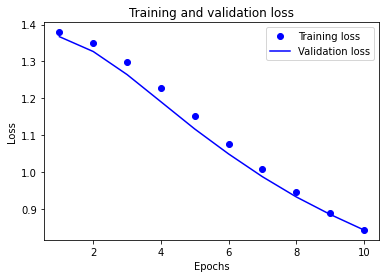

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

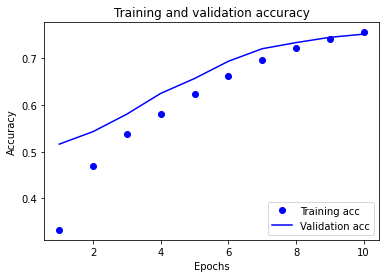

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [29]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 2s 9ms/step - loss: 0.8740 - accuracy: 0.7289
0.7288749814033508


In [30]:
examples = [
    'print',
    'return',
    'console.log'
]

export_model.predict(examples)

1/1 [==============================] - 0s 144ms/step


array([[0.5101408 , 0.45655122, 0.54964274, 0.490123  ],
       [0.514194  , 0.46937594, 0.5608624 , 0.4577665 ],
       [0.50998735, 0.4545778 , 0.5772423 , 0.46053925]], dtype=float32)